In [1]:

!wget -q https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv

!ls housing.csv



housing.csv


In [2]:
import pandas as pd

df = pd.read_csv('housing.csv')
df['ocean_proximity'].value_counts()


,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [3]:
df_shuf = df.sample(frac=1.0, random_state=1)
one_hot = pd.get_dummies(df_shuf['ocean_proximity'])
df_clean = pd.concat([df_shuf.drop('ocean_proximity', axis=1), one_hot], axis=1)


In [4]:
cols_order = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income',
              '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'median_house_value']
df_clean = df_clean[cols_order]
df_clean = df_clean.dropna()
print(f"Current data size: {len(df_clean)}")


Current data size: 20433


In [5]:
df_train = df_clean[:18000]
df_test = df_clean[18000:19217]
df_val = df_clean[19215:]

X_train, y_train = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values
X_test, y_test = df_test.iloc[:, :-1].values, df_test.iloc[:, -1].values
X_val, y_val = df_val.iloc[:, :-1].values, df_val.iloc[:, -1].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((18000, 13), (18000,), (1218, 13), (1218,), (1217, 13), (1217,))

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler().fit(X_train[:, :8])

def scale_features(X):
    X_copy = np.copy(X)
    X_copy[:, :8] = scaler.transform(X_copy[:, :8])
    return X_copy

X_train = scale_features(X_train)
X_val = scale_features(X_val)
X_test = scale_features(X_test)

X_train.shape, X_val.shape, X_test.shape


((18000, 13), (1218, 13), (1217, 13))

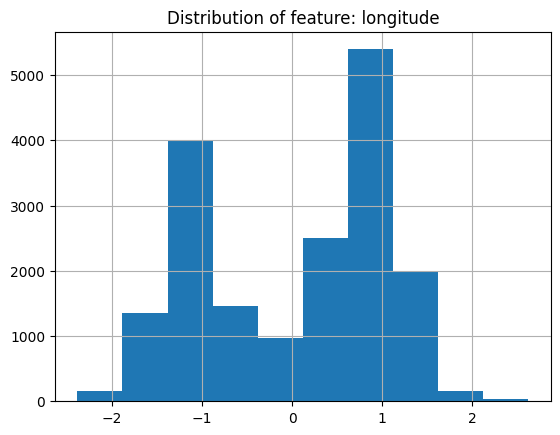

In [7]:
import matplotlib.pyplot as plt

pd.DataFrame(X_train)[0].hist()
plt.title("Distribution of feature: longitude")
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error as rmse
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np


In [11]:
lr = LinearRegression().fit(X_train, y_train)
print("Linear Regression:", np.sqrt(rmse(y_train, lr.predict(X_train))), np.sqrt(rmse(y_val, lr.predict(X_val))))

knn = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)
print("KNN:", np.sqrt(rmse(y_train, knn.predict(X_train))), np.sqrt(rmse(y_val, knn.predict(X_val))))

rf = RandomForestRegressor(max_depth=10).fit(X_train, y_train)
print("Random Forest:", np.sqrt(rmse(y_train, rf.predict(X_train))), np.sqrt(rmse(y_val, rf.predict(X_val))))

gb = GradientBoostingRegressor(n_estimators=250).fit(X_train, y_train)
print("Gradient Boosting:", np.sqrt(rmse(y_train, gb.predict(X_train))), np.sqrt(rmse(y_val, gb.predict(X_val))))


Linear Regression: 68593.05578127236 71382.43558330165
KNN: 53759.09908812057 62161.22860469906
Random Forest: 43473.36837275238 53425.883990641436
Gradient Boosting: 47274.82259072158 51353.501285098435


In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import os
os.makedirs('models', exist_ok=True)


In [16]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


In [20]:
model_big = Sequential([
    InputLayer((13,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_big.compile(optimizer=Adam(learning_rate=0.1), loss='mse', metrics=[RootMeanSquaredError()])
ckpt_big = ModelCheckpoint('models/model_big.keras', save_best_only=True)
model_big.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[ckpt_big], epochs=100)

model_big = load_model('models/model_big.keras')
print("NN:", np.sqrt(rmse(y_train, model_big.predict(X_train))), np.sqrt(rmse(y_val, model_big.predict(X_val))))


Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 10249634816.0000 - root_mean_squared_error: 98199.2969 - val_loss: 6223503360.0000 - val_root_mean_squared_error: 78889.1875
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4538130432.0000 - root_mean_squared_error: 67353.7969 - val_loss: 5290850816.0000 - val_root_mean_squared_error: 72738.2344
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4137719040.0000 - root_mean_squared_error: 64319.0742 - val_loss: 4471029248.0000 - val_root_mean_squared_error: 66865.7578
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3969372672.0000 - root_mean_squared_error: 62972.8242 - val_loss: 3883484416.0000 - val_root_mean_squared_error: 62317.6094
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3803932160.0000 - root_mean_squared_error: 61664.2148 - val_loss: 5156384768.0000 - val_root_mean_squared_error: 71807.9688
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3887535360.00

In [21]:
print("Best Test RMSE (Gradient Boosting):", np.sqrt(rmse(y_test, gb.predict(X_test))))


Best Test RMSE (Gradient Boosting): 49311.57949022798
